# Analysis of Reported Crimes in Chicago from 2003 to 2018

#### Ilango Gopalan, December 2019

## Introduction

Chicago has frequently made the news for its high murder rate and gun violence, including being admonished by the Trump Administration in 2017.  However, overall crime and homicides decreased year over year, making the city safer today despite what various news sources report. 

This project analyzes reported crimes across Chicago, from 2003 through 2018.  The readers of this report will be able to understand the following upon completion:

### 1. Is Chicago safer today in their respective neighborhood
### 2. Learn where the majority of crimes (both violent and non-violent) occur, by neighborhood
### 3. Has gun violence increased or decreased
### 4. Where gun violence or homicides may occur 
### 5. What factors such as location, date, even 'Arrest' would contribute to a crime being gun related?  
### 6. Also, what factors such as location and crime result in an arrest?  

## Dataset

I acquired this dataset from Chicago Data Portal: 

**https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present-Dashboard/5cd6-ry5g**

There are 22 features (mostly of a categorical nature) with 5.7 million records, each one representing a single reported crime from 2003 through 2018.  

### Brief Description of some of the variables:

* ID / Case Number - unique identifiers of the reported instance of crime

* Date / Year - two different date features representing when the incident occurred (best estimate)

* Block - Address with just the first 3 digits (rest redacted), and a direction along with street; Chicago operates on a grid system, therefore all streets have one of the following - N, S, E, W

* IUCR / FBI Code - Illinois Uniform Crime Reporting Codes and FBI Codes for categories of crime

* Primary Type / Description - categorical values of the incident.Example: **Homicide** to Primary Type, and **Handgun** to Description

* Location Description - Residence, Apartment, Street...

* Arrest - Binary of Yes/No

* Beat / District - Police Beat and one of the 25 Districts within Chicago

* Ward / Community Area - Chicago has 50 Wards and 77 Community Areas

* X / Y Coordinates / Latitude / Longitude - All Location variables



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as stats
import datetime
import time
import pyarrow
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from itertools import cycle
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
pd.set_option('display.max_columns', 50)

In [2]:
crimes = pd.read_csv(('Crimes_-_2001_to_present.csv.xz'))

C:\Users\ilang\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Cleaning

The dataset does not have complete information for years **2001, 2002, and 2019**, and I will remove records from those periods.  
Other features cannot be converted until the **NaN and Null** values have been removed.  As shown below, there are only 2 features with NaN values comprising over 1% of the entire dataset - **Ward** and **Community Area**.  Since Ward and Community Area NaN values are still less than 10% of the entire dataset, AND are **categorical values**,  I am choosing to drop those records.

### Features that will be converted OR dropped:

1. ID / Case Number / IUCR / Beat / FBI Code /Block / Domestic / X Coordinate / Y Coordinate / Updated On / Location - **DROPPED**
2. Date - from string to **datetime**
3. District / Ward / Community Area - from float to **integer**


In [3]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032560 entries, 0 to 7032559
Data columns (total 22 columns):
ID                      int64
Case Number             object
Date                    object
Block                   object
IUCR                    object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                object
X Coordinate            float64
Y Coordinate            float64
Year                    int64
Updated On              object
Latitude                float64
Longitude               float64
Location                object
dtypes: bool(2), float64(7), int64(3), object(10)
memory usage: 1.1+ GB


## Feature Conversion

### Date Modification

Currently, 'Date' is a string.  I will split 'Date' into
1. month, day, year
2. Time 


Then I will convert time to **military 24 hour format** 

In [4]:
print(crimes.Date[0].split()) #Separating the string into date, time, AM/PM

['01/01/2001', '11:00:00', 'AM']


In [5]:
#Creating 3 new columns for crime event as date, time, and AM/PM
crimes['Crime_dates'] = crimes.Date.apply(lambda x: x.split()[0])
crimes['Crime_time'] = crimes.Date.apply(lambda x: x.split()[1:3])
#crimes['Crime_AM_PM'] = crimes.Date.apply(lambda x: x.split()[2])

In [6]:
crimes.Crime_time[0][-2]

'11:00:00'

In [7]:
crimes.Crime_time[0][-1:]   #-1 will give me AM or PM

['AM']

In [8]:
crimes.Crime_time[0][0][0:2] #[0][0:2] will give me first 2 digits aka hours

'11'

In [9]:
int(crimes.Crime_time[0][0][:2] )

11

In [10]:
def convert24(str1): 
      
    # Checking if last two elements of time 
    # is AM and first two elements are 12 
    if str1[0][-1:] == "AM" and str1[0][:2] == "12": 
        return "00" +str1[0][:2]
          
    # remove the AM     
    elif str1[0][-1:] == "AM": 
        return str1[0][:2] 
      
    # Checking if last two elements of time 
    # is PM and first two elements are 12    
    elif str1[0][-1:] == "PM" and str1[0][:2] == "12": 
        return str1[0][:-1] 
          
    else: 
          
        # add 12 to hours and remove PM 
        return int(str1[0][:2]) + 12 

In [11]:
crimes['Crime_time'] = crimes['Crime_time'].apply(convert24)

In [12]:
crimes.Crime_time.max()

24

In [13]:
#just separate the hours from the minuts and round the minutes each to the nearest 30. 
#Then convert the hours along to mil time and lose the AM/PM all together.

In [14]:
crimes.Crime_time[100]

19

In [15]:
crimes.isnull().sum()*100/crimes.isnull().count()

ID                      0.000000
Case Number             0.000057
Date                    0.000000
Block                   0.000000
IUCR                    0.000000
Primary Type            0.000000
Description             0.000000
Location Description    0.085175
Arrest                  0.000000
Domestic                0.000000
Beat                    0.000000
District                0.000668
Ward                    8.742620
Community Area          8.723651
FBI Code                0.000000
X Coordinate            0.955925
Y Coordinate            0.955925
Year                    0.000000
Updated On              0.000000
Latitude                0.955925
Longitude               0.955925
Location                0.955925
Crime_dates             0.000000
Crime_time              0.000000
dtype: float64

In [16]:
crimes = crimes[crimes.Year != 2001]
crimes = crimes[crimes.Year != 2002]
crimes = crimes[crimes.Year != 2019]


In [17]:
crimes = crimes[['Crime_dates', 'Crime_time', 'Primary Type', 'Description', 
                 'Arrest', 'District', 'Ward', 'Community Area', 'Year', 'Latitude', 'Longitude', 'Location']]

In [18]:
crimes.Year.unique()

array([2017, 2013, 2015, 2012, 2014, 2006, 2011, 2007, 2010, 2008, 2016,
       2003, 2018, 2009, 2005, 2004], dtype=int64)

In [19]:
crimes = crimes.dropna()

In [20]:
crimes.isnull().sum() #There are zero null or NaN values, and now specific features can be modified

Crime_dates       0
Crime_time        0
Primary Type      0
Description       0
Arrest            0
District          0
Ward              0
Community Area    0
Year              0
Latitude          0
Longitude         0
Location          0
dtype: int64

### District / Ward / Community Area - from float to integer

In [21]:
crimes.District = crimes.District.astype(int)
crimes.Ward = crimes.Ward.astype(int)
crimes['Community Area'] = crimes['Community Area'].astype(int)

In [22]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5765494 entries, 64183 to 7032553
Data columns (total 12 columns):
Crime_dates       object
Crime_time        int64
Primary Type      object
Description       object
Arrest            bool
District          int32
Ward              int32
Community Area    int32
Year              int64
Latitude          float64
Longitude         float64
Location          object
dtypes: bool(1), float64(2), int32(3), int64(2), object(4)
memory usage: 467.4+ MB


## Data Exploration

### I want to display bar charts to compare total arrests vs. no arrests

### Groupby Year by the highest frequency of crimes, so Year by Theft; Year by Battery; then Year by Handgun

### Histogram 

### Scatter Plot of Latitude and Longitude

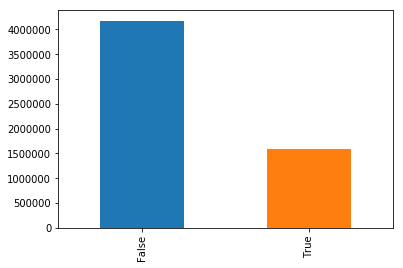

In [23]:
crimes.Arrest.value_counts().plot.bar()  #Total arrests vs. no arrests.  
#This could explain why people feel that Chicago is crime-ridden especially if crimes appear unsolved

In [24]:
type(crimes.Year.iloc[0])

numpy.int64

Text(0, 0.5, 'Total Crimes')

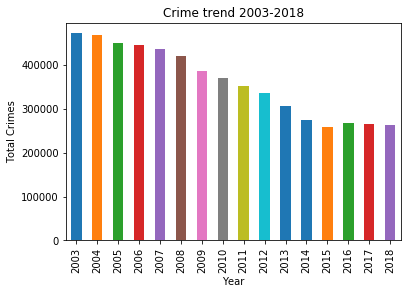

In [25]:
crimes.Year.value_counts(sort=False).plot.bar(title = 'Crime trend 2003-2018')
plt.xlabel('Year')
plt.ylabel('Total Crimes')

In [26]:
crimes['Primary Type'].unique()

array(['ROBBERY', 'OFFENSE INVOLVING CHILDREN', 'CRIM SEXUAL ASSAULT',
       'SEX OFFENSE', 'OTHER OFFENSE', 'BATTERY', 'ASSAULT',
       'HUMAN TRAFFICKING', 'DECEPTIVE PRACTICE', 'BURGLARY',
       'WEAPONS VIOLATION', 'CRIMINAL TRESPASS', 'CRIMINAL DAMAGE',
       'PUBLIC PEACE VIOLATION', 'THEFT', 'INTIMIDATION', 'ARSON',
       'HOMICIDE', 'OBSCENITY', 'MOTOR VEHICLE THEFT', 'KIDNAPPING',
       'STALKING', 'INTERFERENCE WITH PUBLIC OFFICER', 'NARCOTICS',
       'GAMBLING', 'CONCEALED CARRY LICENSE VIOLATION', 'PROSTITUTION',
       'LIQUOR LAW VIOLATION', 'PUBLIC INDECENCY',
       'OTHER NARCOTIC VIOLATION', 'NON - CRIMINAL', 'NON-CRIMINAL',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'RITUALISM'], dtype=object)

In [27]:
crimes['Description'].unique()

array(['STRONGARM - NO WEAPON', 'CRIM SEX ABUSE BY FAM MEMBER',
       'PREDATORY', 'AGG CRIM SEX ABUSE FAM MEMBER',
       'SEX ASSLT OF CHILD BY FAM MBR', 'AGG SEX ASSLT OF CHILD FAM MBR',
       'ATT AGG CRIMINAL SEXUAL ABUSE', 'HARASSMENT BY ELECTRONIC MEANS',
       'NON-AGGRAVATED', 'SIMPLE', 'AGGRAVATED: HANDGUN',
       'AGG PRO.EMP: HANDGUN', 'AGGRAVATED:KNIFE/CUTTING INSTR',
       'COMMERCIAL SEX ACTS', 'AGG CRIMINAL SEXUAL ABUSE',
       'SEX OFFENDER: FAIL REG NEW ADD', 'AGGRAVATED: OTHER',
       'HARBOR RUNAWAY', 'CREDIT CARD FRAUD',
       'VIOLATE ORDER OF PROTECTION', 'PRO EMP HANDS NO/MIN INJURY',
       'AGGRAVATED PO: OTHER DANG WEAP', 'FORCIBLE ENTRY',
       'TELEPHONE THREAT',
       'AGGRAVATED DOMESTIC BATTERY: KNIFE/CUTTING INST',
       'UNLAWFUL POSS OF HANDGUN', 'RECKLESS FIREARM DISCHARGE',
       'ARMED: HANDGUN', 'DOMESTIC BATTERY SIMPLE',
       'AGG: HANDS/FIST/FEET SERIOUS INJURY', 'AGGRAVATED PO: HANDGUN',
       'TO VEHICLE', 'TO PROPERTY', 'ARSON 

In [28]:
crimes.groupby(['Year', 'Description']).size()

Year  Description                                                
2003  $500 AND UNDER                                                 36773
      ABUSE/NEGLECT: CARE FACILITY                                      11
      ADULTRY                                                            1
      AGG CRIM SEX ABUSE FAM MEMBER                                    135
      AGG CRIMINAL SEXUAL ABUSE                                        444
      AGG PO HANDS ETC SERIOUS INJ                                      19
      AGG PO HANDS NO/MIN INJURY                                       956
      AGG PRO EMP HANDS SERIOUS INJ                                     18
      AGG PRO.EMP: HANDGUN                                              42
      AGG PRO.EMP: OTHER DANG WEAPON                                   187
      AGG PRO.EMP: OTHER FIREARM                                        17
      AGG PRO.EMP:KNIFE/CUTTING INST                                    41
      AGG RIT MUT: HANDS/FIST/FEET

In [29]:
# crimes.str.contains('HANDGUN')
crimes.Description.str.contains('HANDGUN').value_counts()/len(crimes)*100

False    96.478619
True      3.521381
Name: Description, dtype: float64

In [30]:
crimes_handguns = crimes.Description.str.contains('HANDGUN')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000024D3E5D82B0>],
      dtype=object)

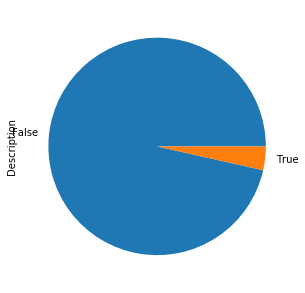

In [31]:
crimes.Description.str.contains('HANDGUN').value_counts().plot.pie(subplots=True, figsize=(5,5))

In [32]:
crimes[crimes['Description'].str.contains('Handgun', case=False)].groupby(['Year']).size()

Year
2003    15391
2004    13815
2005    13317
2006    12977
2007    12536
2008    13966
2009    13759
2010    12001
2011    12004
2012    12360
2013     9959
2014     9632
2015    10566
2016    13775
2017    13970
2018    12997
dtype: int64

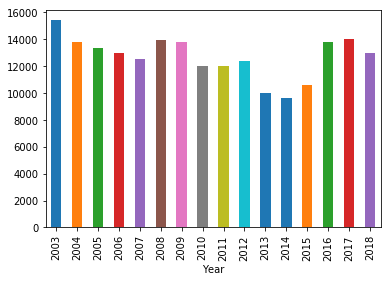

In [33]:
crimes[crimes['Description'].str.contains('Handgun', case=False)].groupby(['Year']).size().plot.bar()

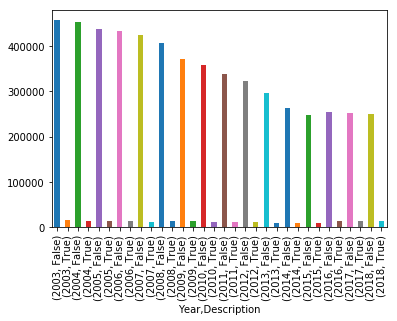

In [34]:
 crimes.groupby(['Year', crimes_handguns]).size().plot.bar()
# crimes.groupby(['Year', crimes_handguns]).plot.bar()

In [35]:
# Groupby Year by the highest frequency of crimes, so Year by Theft; Year by Battery; then Year by Handgun

# df_clean.groupby(['ADDRESS'])['VIOLATIONS'].sum().nlargest()

# crimes(['Primary Type'] == 'HOMICIDE').value_counts()
crimes['Primary Type'].value_counts()

THEFT                                1217604
BATTERY                              1047867
CRIMINAL DAMAGE                       660822
NARCOTICS                             603094
ASSAULT                               357065
OTHER OFFENSE                         356328
BURGLARY                              336836
MOTOR VEHICLE THEFT                   261989
DECEPTIVE PRACTICE                    228118
ROBBERY                               219453
CRIMINAL TRESPASS                     166508
WEAPONS VIOLATION                      62566
PROSTITUTION                           55712
PUBLIC PEACE VIOLATION                 42657
OFFENSE INVOLVING CHILDREN             38766
CRIM SEXUAL ASSAULT                    22499
SEX OFFENSE                            19852
INTERFERENCE WITH PUBLIC OFFICER       14480
GAMBLING                               12449
LIQUOR LAW VIOLATION                   10969
ARSON                                   9145
HOMICIDE                                8173
KIDNAPPING

In [36]:
crimes[crimes['Primary Type'].str.contains('HOMICIDE', case=False)].groupby(['Year']).size()

Year
2003    586
2004    436
2005    453
2006    476
2007    448
2008    513
2009    460
2010    438
2011    438
2012    515
2013    429
2014    426
2015    502
2016    788
2017    674
2018    591
dtype: int64

## Modeling

### I will begin with Random Forest

##### Hierarchical Clustering if necessary, DBSCAN


### Make dummies for 

1. Primary Type as HOMICIDE =1, non_homicide = 0 separate feature **Homicide**
2. Description as HANDGUN = 1, non_gun = 0 separate feature **Gun_Involvement**

### Note: HOMICIDE and Gun_Involvement do not overlap, so this report will not clearly show fatalities due to guns
### Note: I am adding a Crime_month feature to denote incident month

In [37]:
crimes.head(1)

,Crime_dates,Crime_time,Primary Type,Description,Arrest,District,Ward,Community Area,Year,Latitude,Longitude,Location
64183,05/27/2016,17,ROBBERY,STRONGARM - NO WEAPON,False,1,25,28,2016,41.869752,-87.639747,"(41.869752476, -87.639747289)"


In [38]:
crimes['Gun_Involved'] = crimes['Description'].apply(lambda x: 1 if 'HANDGUN' in x  else 0)

In [39]:
crimes['Homicide'] = crimes['Primary Type'].apply(lambda x: 1 if 'HOMICIDE' in x  else 0)

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

In [41]:
crimes.Gun_Involved.value_counts()

0    5562469
1     203025
Name: Gun_Involved, dtype: int64

In [42]:
crimes.Homicide.value_counts()

0    5757321
1       8173
Name: Homicide, dtype: int64

In [43]:
crimes.columns

Index(['Crime_dates', 'Crime_time', 'Primary Type', 'Description', 'Arrest',
       'District', 'Ward', 'Community Area', 'Year', 'Latitude', 'Longitude',
       'Location', 'Gun_Involved', 'Homicide'],
      dtype='object')

In [44]:
crimes.Crime_dates.head(1)

64183    05/27/2016
Name: Crime_dates, dtype: object

In [46]:
crimes.Crime_dates = pd.to_datetime(crimes.Crime_dates)

In [47]:
Crime_month = crimes['Crime_dates'].dt.month

In [48]:
crimes['Crime_month'] = Crime_month

In [49]:
crimes.head(1)

,Crime_dates,Crime_time,Primary Type,Description,Arrest,District,Ward,Community Area,Year,Latitude,Longitude,Location,Gun_Involved,Homicide,Crime_month
64183,2016-05-27,17,ROBBERY,STRONGARM - NO WEAPON,False,1,25,28,2016,41.869752,-87.639747,"(41.869752476, -87.639747289)",0,0,5


## Decision Trees and Random Forest

5. What factors such as location, date, even 'Arrest' would contribute to a crime being gun related?
6. Also, what factors such as location and crime result in an arrest?

In [58]:
#Will a crime involve a gun?
X = crimes[['Crime_month', 'Crime_time','Arrest', 'Latitude', 'Longitude',
       'District', 'Ward', 'Community Area', 'Year']]
#Question for Magdalena, should I remove Lat/Long?

In [59]:
y = crimes.Gun_Involved

In [63]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

In [64]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(
    criterion = 'entropy',
    max_features = 1,
    max_depth = 4,
    random_state = 1337
)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=1, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1337, splitter='best')

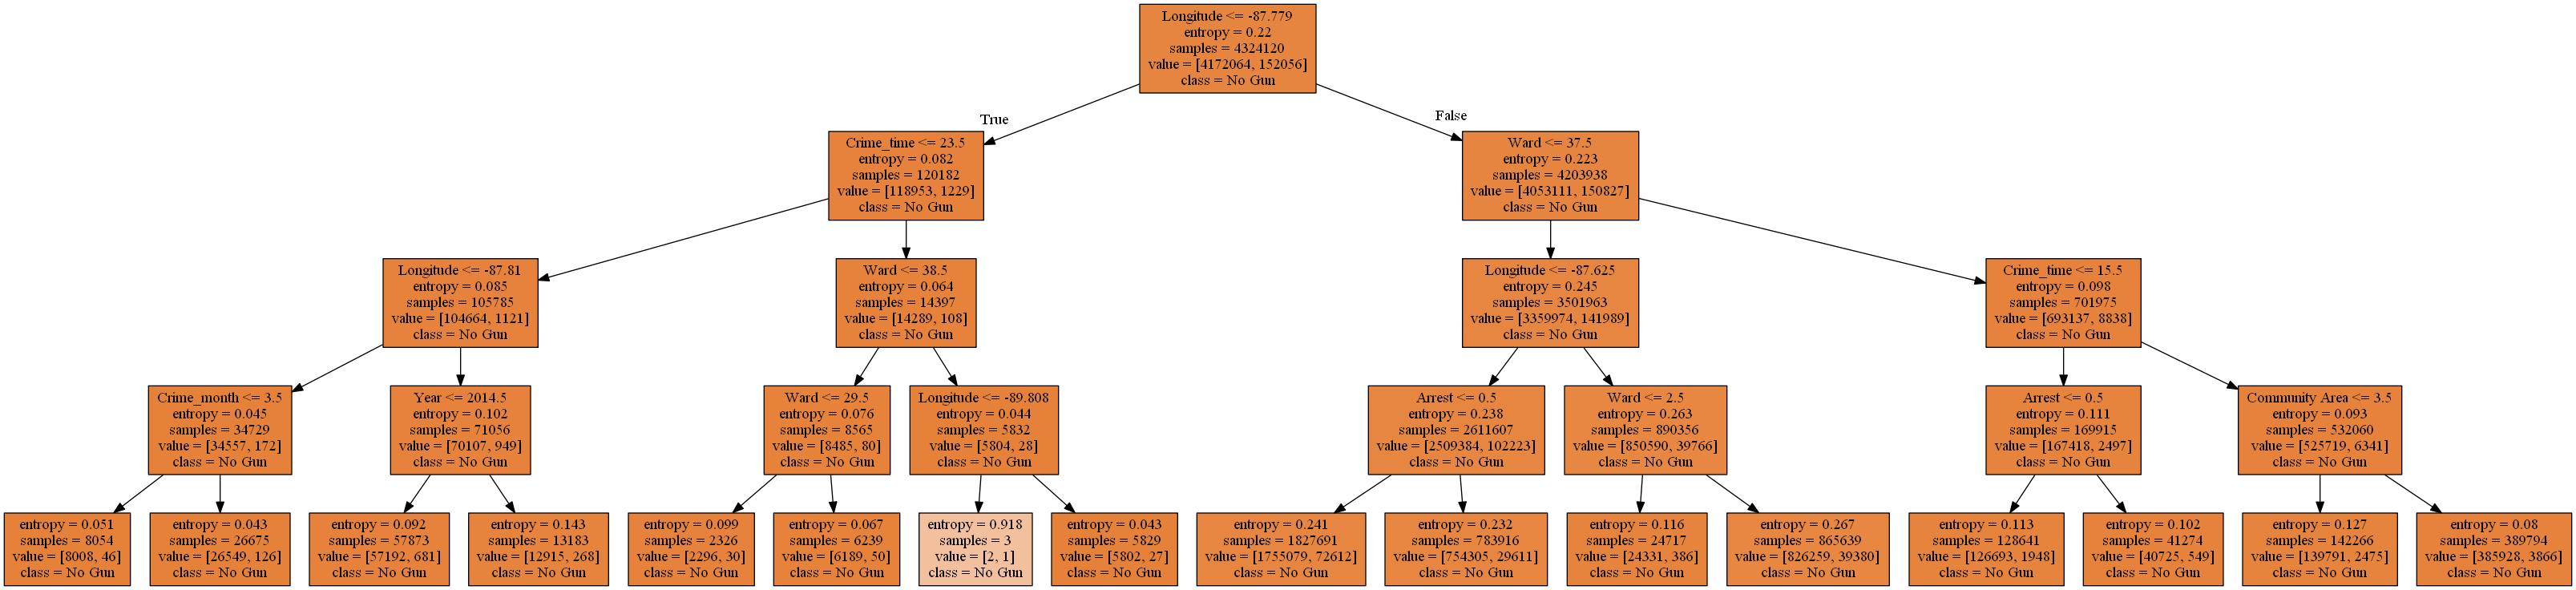

In [81]:
# Render our tree.
dot_data = tree.export_graphviz(
    dt, out_file=None,
    feature_names=X_train.columns,
    class_names = ['No Gun', 'Gun'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
#if i want to run randmo forest to predict which ward will have crime, remove location lat/lon/ district from my new X

In [92]:
## Run the decision tree again but this time drop lat/long

#Will a crime involve a gun?
X = crimes[['Crime_month', 'Crime_time','Arrest', 'District', 'Ward', 'Community Area', 'Year']]
y = crimes.Gun_Involved

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

dt = DecisionTreeClassifier(
    criterion = 'entropy',
    max_features = 7,
    max_depth = 4,
    random_state = 1337
)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1337, splitter='best')

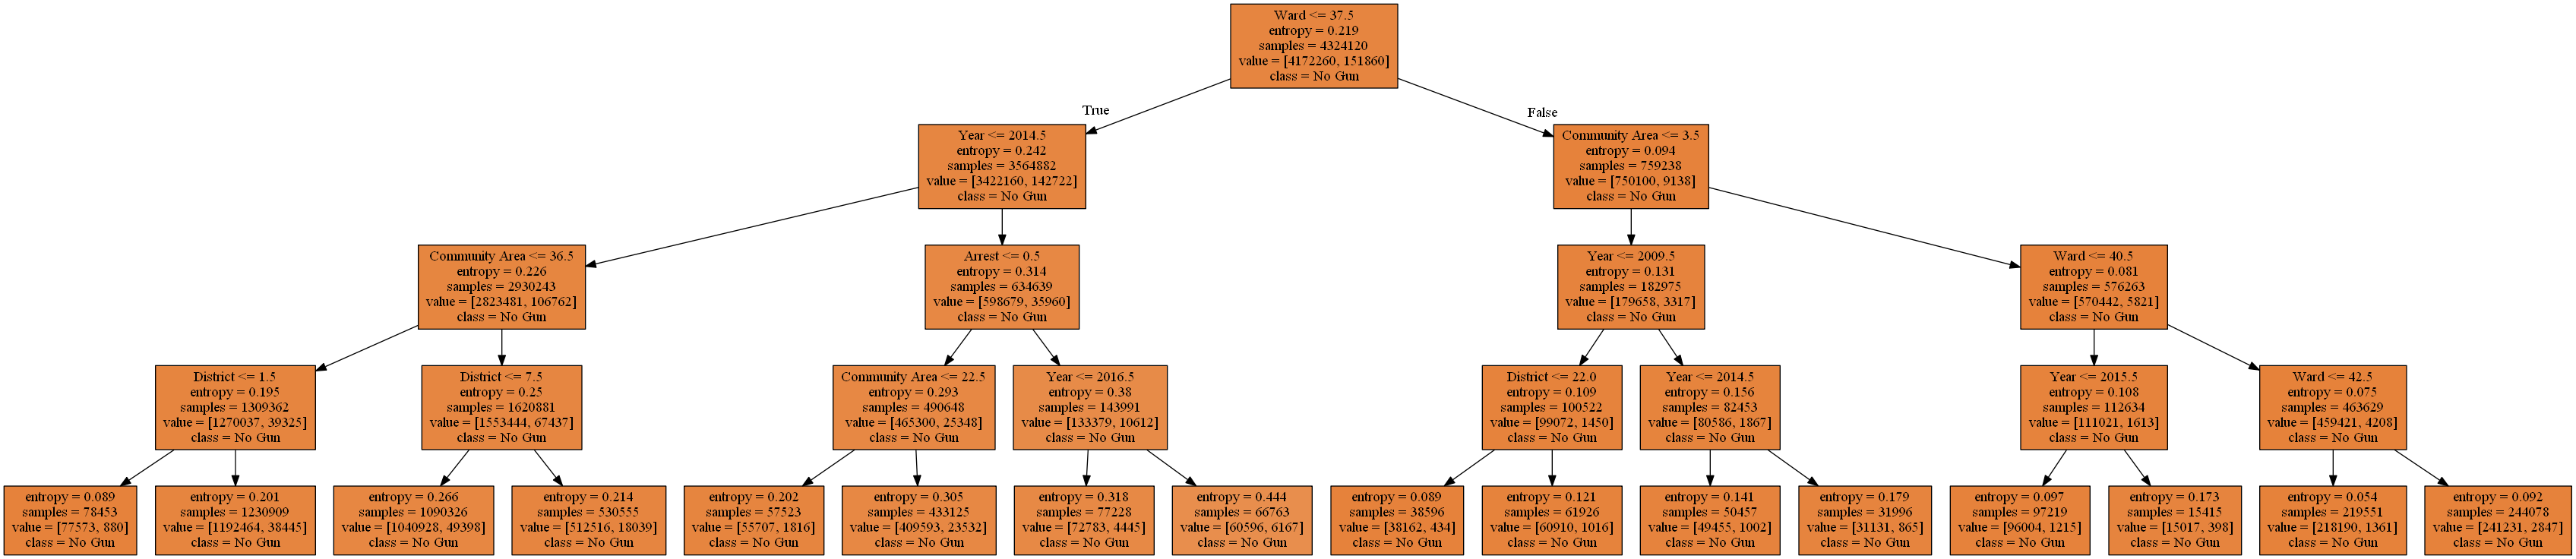

In [93]:
# Render our tree.
dot_data = tree.export_graphviz(
    dt, out_file=None,
    feature_names=X_train.columns,
    class_names = ['No Gun', 'Gun'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## Since there is a major imbalance between Gun and No Gun crimes, that could explain why there isn't a single leaf with Gun.

## Let's view decision trees based on arrests

In [94]:
## Run the decision tree again but this time drop lat/long

#Will a crime involve a gun?
X = crimes[['Crime_month', 'Crime_time', 'District', 'Ward', 'Community Area', 'Year']]
y = crimes.Arrest

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

dt = DecisionTreeClassifier(
    criterion = 'entropy',
    max_features = 6,
    max_depth = 3,
    random_state = 1337
)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1337, splitter='best')

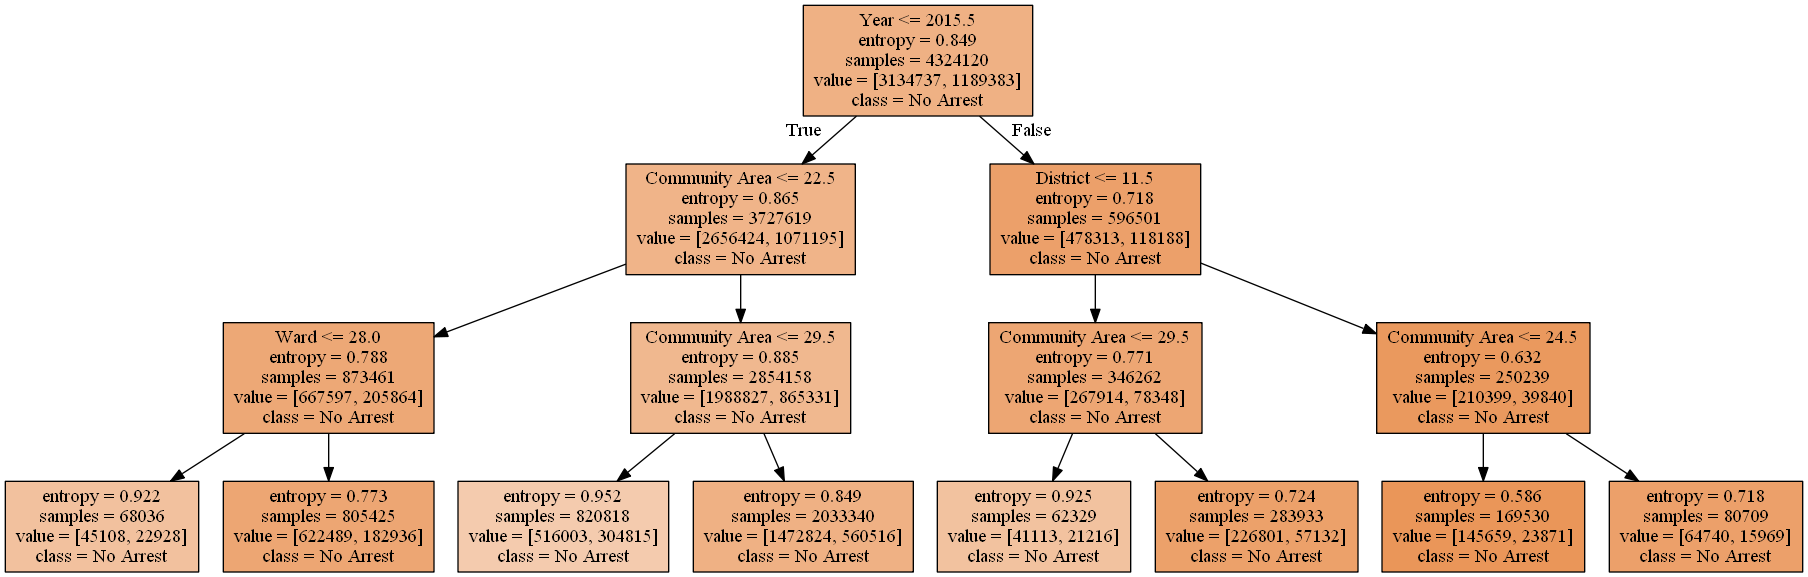

In [95]:
# Render our tree.
dot_data = tree.export_graphviz(
    dt, out_file=None,
    feature_names=X_train.columns,
    class_names = ['No Arrest', 'Arrest'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [88]:
3134571+1189549

4324120

In [107]:
from sklearn.model_selection import cross_val_score

In [110]:
from sklearn.metrics import roc_curve, auc

In [111]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

In [112]:
roc_auc = auc(false_positive_rate, true_positive_rate)

In [113]:
roc_auc

0.5

In [103]:
predictions = dt.predict(X_test)

In [104]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [105]:
print('Accuracy score:' , accuracy_score(y_test, predictions))
print('Precision score:' , precision_score(y_test, predictions))
print('Recall score:' , recall_score(y_test, predictions))

Accuracy score: 0.72477788554532


C:\Users\ilang\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision score: 0.0
Recall score: 0.0


In [109]:
dt.classes_

array([False,  True])

## Major class imbalance for predicting if an arrest was made or a gun was involved.  Let's now see if the month can be predicted for a crime.  Note that the 12 months are more balanced.

In [87]:
crimes.Crime_month.value_counts()

7     536335
8     532078
5     515651
6     511891
10    501924
9     498044
4     475963
3     475683
11    452785
1     446650
12    425284
2     393206
Name: Crime_month, dtype: int64

In [116]:
#What month will crimes occur?
X = crimes[['Crime_time', 'District', 'Ward', 'Community Area', 'Year', 'Arrest', 'Gun_Involved']]
y = crimes.Crime_month

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

dt = DecisionTreeClassifier(
    criterion = 'entropy',
    max_features = 6,
    max_depth = 4,
    random_state = 1337
)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1337, splitter='best')

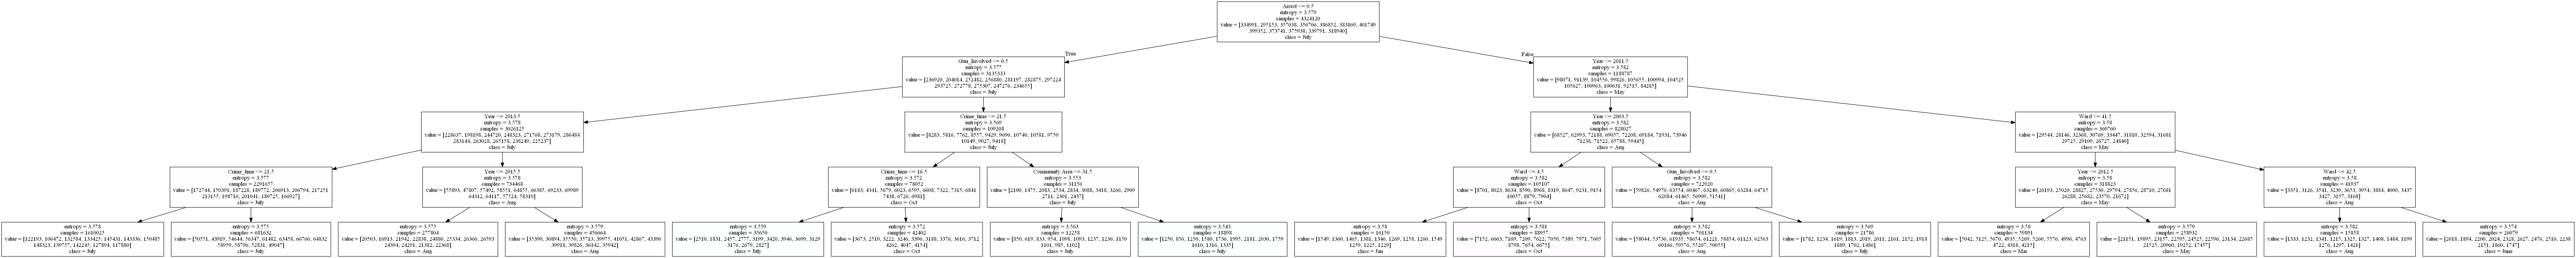

In [117]:
# Render our tree.
dot_data = tree.export_graphviz(
    dt, out_file=None,
    feature_names=X_train.columns,
    class_names = ['Jan', "Feb", 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

# A new direction will be taken on this project.  Given that there is a large imbalance for crimes involving guns, homicides, and arrests, the current models will not produce meaningful results.  Therefore, I am dividing up the incidents according to the FBI Uniform Crime Reporting Program, which  categorizes crimes as  "Violent Crime" and "Property Crime".  


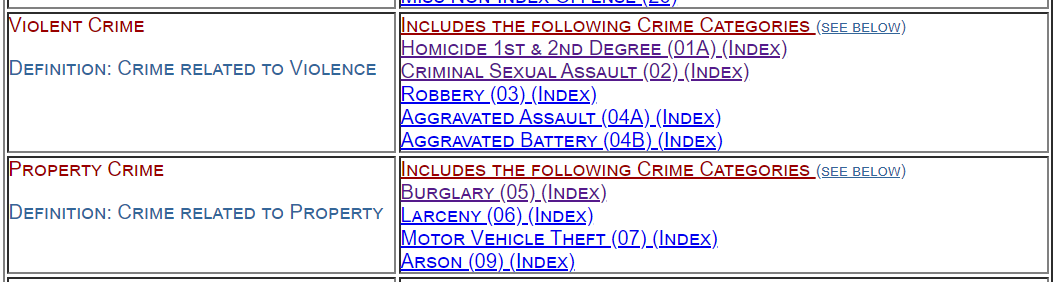

UCR crime categories

FBI Crime Clock – 2014

Violent and Property Crime Indexes per 100,000 population, 2004 Uniform Crime Report
For reporting purposes, criminal offenses are divided into two major groups: Part I offenses and Part II offenses.

In Part I, the UCR indexes reported incidents of index crimes which are broken into two categories: violent and property crimes. Aggravated assault, forcible rape, murder, and robbery are classified as violent while arson, burglary, larceny-theft, and motor vehicle theft are classified as property crimes. These are reported via the document named Return A – Monthly Return of Offenses Known to the Police. Part 1 crimes are collectively known as Index crimes, this name is used because the crimes are considered quite serious, tend to be reported more reliably than others, and are reported directly to the police and not to a separate agency (ex- IRS) that doesn't necessarily contribute to the UCR.

In Part II, the following categories are tracked: simple assault, curfew offenses and loitering, embezzlement, forgery and counterfeiting, disorderly conduct, driving under the influence, drug offenses, fraud, gambling, liquor offenses, offenses against the family, prostitution, public drunkenness, runaways, sex offenses, stolen property, vandalism, vagrancy, and weapons offenses.

In [122]:
crimes['Primary Type'].value_counts()

#Violent 
Homicide 1st & 2nd Degree (01A) (Index) 8173
Criminal Sexual Assault (02) (Index) 22499
Robbery (03) (Index) 219453
Aggravated Assault (04A) (Index) 357065
Aggravated Battery (04B) (Index) 1047867

#Property 
Burglary (05) (Index) 336836
Larceny aka theft (06) (Index) 1217604
Motor Vehicle Theft (07) (Index)261989
Arson (09) (Index) 9145

THEFT                                1217604
BATTERY                              1047867
CRIMINAL DAMAGE                       660822
NARCOTICS                             603094
ASSAULT                               357065
OTHER OFFENSE                         356328
BURGLARY                              336836
MOTOR VEHICLE THEFT                   261989
DECEPTIVE PRACTICE                    228118
ROBBERY                               219453
CRIMINAL TRESPASS                     166508
WEAPONS VIOLATION                      62566
PROSTITUTION                           55712
PUBLIC PEACE VIOLATION                 42657
OFFENSE INVOLVING CHILDREN             38766
CRIM SEXUAL ASSAULT                    22499
SEX OFFENSE                            19852
INTERFERENCE WITH PUBLIC OFFICER       14480
GAMBLING                               12449
LIQUOR LAW VIOLATION                   10969
ARSON                                   9145
HOMICIDE                                8173
KIDNAPPING

In [139]:
#Create a feature for Violent_Property, based on the Primary Type Descriptions



def viol_prop(x):
    
    if x == 'HOMICIDE' or x == 'CRIM SEXUAL ASSAULT' or x == 'ROBBERY' or x == 'ASSAULT' or x == 'BATTERY':
        return "Violent"
    elif x == 'BURGLARY' or x== 'THEFT' or x == 'MOTOR VEHICLE THEFT' or x == 'ARSON':
        return "Property"
    else:
        return "Other"
    
    
crimes['Violent_or_Property'] = crimes['Primary Type'].apply(viol_prop)



In [140]:
crimes.Violent_or_Property.value_counts()

Other       2284863
Property    1825574
Violent     1655057
Name: Violent_or_Property, dtype: int64

In [142]:
crimes = crimes[crimes.Violent_or_Property != 'Other']

In [144]:
crimes.Violent_or_Property.value_counts()

Property    1825574
Violent     1655057
Name: Violent_or_Property, dtype: int64

In [145]:
crimes.head(1)

,Crime_dates,Crime_time,Primary Type,Description,Arrest,District,Ward,Community Area,Year,Latitude,Longitude,Location,Gun_Involved,Homicide,Crime_month,Violent_or_Property
64183,2016-05-27,17,ROBBERY,STRONGARM - NO WEAPON,False,1,25,28,2016,41.869752,-87.639747,"(41.869752476, -87.639747289)",0,0,5,Violent


In [149]:
#Based on time and location, can we predict if a crime is violent or property based?
X = crimes[['Crime_time', 'District', 'Ward', 'Community Area', 'Year', 'Arrest', 'Gun_Involved', 'Homicide', 'Crime_month']]
y = crimes.Violent_or_Property

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

dt = DecisionTreeClassifier(
    criterion = 'entropy',
    max_features = 6,
    max_depth = 2,
    random_state = 1337
)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1337, splitter='best')

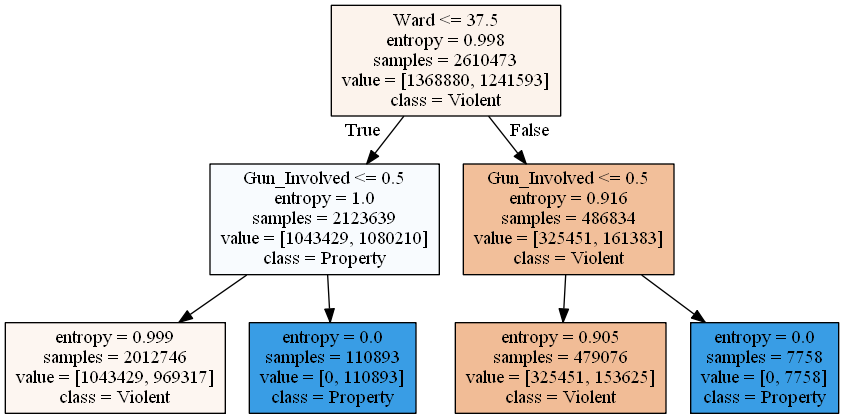

In [150]:
# Render our tree.
dot_data = tree.export_graphviz(
    dt, out_file=None,
    feature_names=X_train.columns,
    class_names = ['Violent', 'Property'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

s Chicago safer today in their respective neighborhood - simple exploration group by trend chart can answer that
Learn where the majority of crimes (both violent and non-violent) occur, by neighborhood - simple exploration
Has gun violence increased or decreased - trending groupby
Where gun violence or homicides or 'violent crime' (murder and assault) or non-violent crime (theft and robbery) may occur  by Ward/District/Community Areacrimes.Arrest.value_counts()/len(crimes)

### !  ok so i should make one of my questions - What factors such as location, date, even 'Arrest' would contribute to a crime being gun related?  
Also, what factors such as location and crime result in an arrest?  Good news is that for the total dataset, 72% No Arrest, 28% Arrest.  So a slightly better imbalance than gun and homicide :wink:
Clustering or even certain plot visualizations in tableau would answer  your above questions. Clustering would answer question 2 and 4 definitely. Also, question 1 can be abswered with a trend plot, thats correct, and question 3 can be answered with a comparison trend plit as well with a histogram or bar chart series.